Streaming output truncated to the last 5000 lines.
Epoch 10/100
17/17 [==============================] - 2s 146ms/step - loss: 1.2542 - accuracy: 0.6105 - val_loss: 1.1748 - val_accuracy: 0.6518
Epoch 11/100
17/17 [==============================] - 2s 143ms/step - loss: 1.2088 - accuracy: 0.6289 - val_loss: 1.1300 - val_accuracy: 0.6731
Epoch 12/100
17/17 [==============================] - 3s 213ms/step - loss: 1.1685 - accuracy: 0.6436 - val_loss: 1.0903 - val_accuracy: 0.6898
Epoch 13/100
17/17 [==============================] - 4s 235ms/step - loss: 1.1263 - accuracy: 0.6611 - val_loss: 1.0551 - val_accuracy: 0.7050
Epoch 14/100
17/17 [==============================] - 2s 142ms/step - loss: 1.0969 - accuracy: 0.6730 - val_loss: 1.0238 - val_accuracy: 0.7164
Epoch 15/100
17/17 [==============================] - 2s 146ms/step - loss: 1.0656 - accuracy: 0.6859 - val_loss: 0.9956 - val_accuracy: 0.7280
Epoch 16/100
17/17 [==============================] - 2s 145ms/step - loss: 1.0416 - 

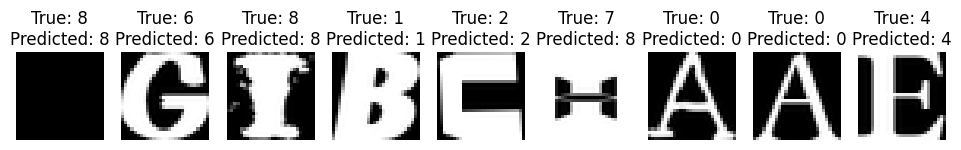

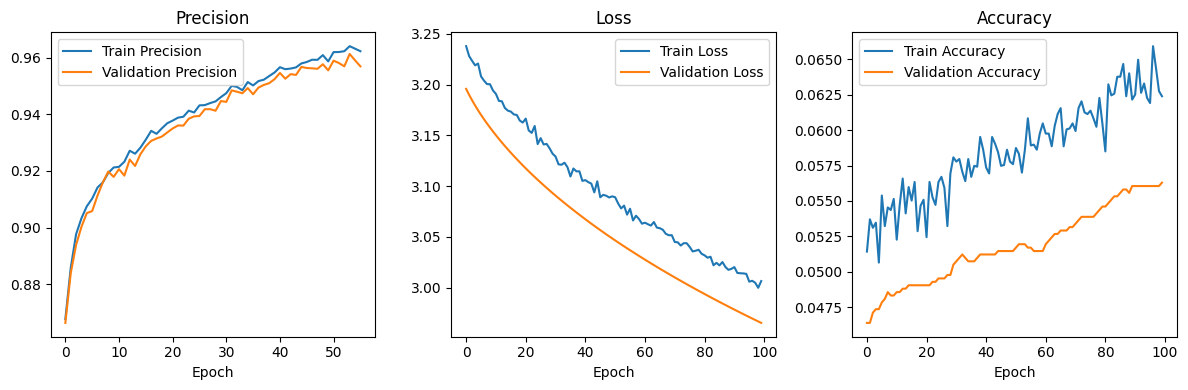

---------
Program execution completed.
---------


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score

from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adagrad
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, Callback

from google.colab import files
from google.colab import drive
import io
drive.mount('/content/drive')

class Sequential_Model:
    def __init__(self, learning_rate, regularization_strength): # No defaults.
        self.model = Sequential()
        self.learning_rate = learning_rate
        self.regularization_strength = regularization_strength
        self.build_model()

    def build_model(self):
        self.model.add(Dense(units=30, activation="relu", kernel_regularizer=l2(self.regularization_strength)))
        self.model.add(Dropout(0.1))
        self.model.add(Dense(units=10, activation="softmax"))
        # The labels are limited to 'A' through 'J' (10 classes).
        # The number of units --neurons in the final dense layer
        # matches the number of classes in this classification task.

        adagrad = Adagrad(learning_rate=self.learning_rate)
        self.model.compile(optimizer=adagrad, loss="categorical_crossentropy", metrics=["accuracy"])

    @staticmethod
    def load_data(data_path):
        data = loadmat(data_path)
        X_temp = data["images"] / 255
        X = np.empty(shape=[X_temp.shape[2]] + [784], dtype="float32")

        for i in range(X_temp.shape[2]):
            X[i, :] = X_temp[:, :, i].flatten()

        y = pd.get_dummies(data["labels"]).to_numpy()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=137, stratify=y)

        mean = X_train.mean()
        std = X_train.std()
        X_train = (X_train - mean) / std
        X_test = (X_test - mean) / std

        return X_train, X_test, y_train, y_test

    def train(self, X_train, y_train, epochs=100, batch_size=1000, validation_data=None, callbacks=None):

        precision_recall_callback = PrecisionRecallCallback(X_train, y_train, validation_data[0], validation_data[1])

        if callbacks is None:
            callbacks = [precision_recall_callback]
        else:
            callbacks.append(precision_recall_callback)

        history = self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=validation_data, callbacks=callbacks)

        return history, precision_recall_callback

    def evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        y_true = np.argmax(y_test, axis=1)
        y_pred = np.argmax(y_pred, axis=1)

        precision = precision_score(y_true, y_pred, average="weighted", zero_division=1)
        recall = recall_score(y_true, y_pred, average="weighted", zero_division=1)

        return precision, recall

    def predict(self, X):
        predictions = self.model.predict(X)
        rounded_predictions = np.round(predictions)

        return rounded_predictions

    @staticmethod
    def display_images_with_labels(images, true_labels, predicted_labels):
        fig, axes = plt.subplots(1, len(images), figsize=(12, 4))

        for i, ax in enumerate(axes):
            ax.imshow(images[i].reshape(28, 28), cmap="gray")
            ax.set_title(f"True: {true_labels[i]}\nPredicted: {predicted_labels[i]}")
            ax.axis("off")

        plt.show()

class PrecisionRecallCallback(Callback):
    def __init__(self, X_train, y_train, X_val, y_val):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.train_precision = []
        self.train_recall = []
        self.val_precision = []
        self.val_recall = []

    def on_epoch_end(self, epoch, logs=None):
        y_train_pred = self.model.predict(self.X_train)
        y_train_true = np.argmax(self.y_train, axis=1)
        y_train_pred = np.argmax(y_train_pred, axis=1)

        train_precision = precision_score(y_train_true, y_train_pred, average="weighted", zero_division=1)
        train_recall = recall_score(y_train_true, y_train_pred, average="weighted", zero_division=1)

        self.train_precision.append(train_precision)
        self.train_recall.append(train_recall)

        y_val_pred = self.model.predict(self.X_val)
        y_val_true = np.argmax(self.y_val, axis=1)
        y_val_pred = np.argmax(y_val_pred, axis=1)

        val_precision = precision_score(y_val_true, y_val_pred, average="weighted", zero_division=1)
        val_recall = recall_score(y_val_true, y_val_pred, average="weighted", zero_division=1)

        self.val_precision.append(val_precision)
        self.val_recall.append(val_recall)

class Plotter:
    def __init__(self):
        pass

    @staticmethod
    def plot_precision(callback, callback_final):
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.plot(callback.train_precision, label="Train Precision")
        plt.plot(callback.val_precision, label="Validation Precision")
        plt.title("Precision")
        plt.xlabel("Epoch")
        plt.legend()

    @staticmethod
    def plot_loss(history):
        plt.subplot(1, 3, 2)
        plt.plot(history.history["loss"], label="Train Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.legend()

    @staticmethod
    def plot_accuracy(history):
        plt.subplot(1, 3, 3)
        plt.plot(history.history["accuracy"], label="Train Accuracy")
        plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
        plt.title("Accuracy")
        plt.xlabel("Epoch")
        plt.legend()
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    model = Sequential_Model(learning_rate=0.01, regularization_strength=0.0001)

    X_train, X_val, y_train, y_val = model.load_data("drive/My Drive/ColabProjects/notMNIST_small.mat")
    # The labels are limited to 'A' through 'J' (10 classes), and
    # 19,000 labelled examples.

    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.33, random_state=42, stratify=y_val)

    learning_rates = [0.10, 0.01, 0.001, 0.0001, 0.00001]
    regularization_strengths = [0.10, 0.01, 0.001, 0.0001, 0.00001]

    best_accuracy = 0
    best_lr = None
    best_reg_strength = None

    early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

    val_precision_list = []
    val_recall_list = []

    for lr in learning_rates:

        for reg_strength in regularization_strengths:
            model = Sequential_Model(learning_rate=lr, regularization_strength=reg_strength)

            history, callback = model.train(
                np.concatenate((X_train, X_val)),
                np.concatenate((y_train, y_val)),
                epochs=100,
                batch_size=1000,
                validation_data=(X_val, y_val),
                callbacks=[early_stopping])


            if callback.val_precision[-1] > best_accuracy:
                best_accuracy = callback.val_precision[-1]
                best_lr = lr
                best_reg_strength = reg_strength

    final_model = Sequential_Model(learning_rate=best_lr, regularization_strength=best_reg_strength)

    history_final, callback_final = final_model.train(
        np.concatenate((X_train, X_val)),
        np.concatenate((y_train, y_val)),
        epochs=100,
        batch_size=1000,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping])

    test_precision, test_recall = final_model.evaluate(X_test, y_test)

    print("---------")
    print("Test Precision (final model):", test_precision)
    print("Test Recall (final model):", test_recall)
    print("---------")

    print("---------")
    print("Best Hyperparameters:")
    print("Best Learning Rate:", best_lr)
    print("Best Regularization Strength:", best_reg_strength)
    print("---------")

    num_images_to_display = 9
    random_indices = np.random.choice(len(X_test), num_images_to_display)
    selected_images = X_test[random_indices]
    true_labels = np.argmax(y_test[random_indices], axis=1)
    predicted_labels = np.argmax(final_model.predict(selected_images), axis=1)

    final_model.display_images_with_labels(selected_images, true_labels, predicted_labels)

    # Create a Plotter instance.
    plotter = Plotter()

    # Plot precision.
    plotter.plot_precision(callback_final, callback)

    # Plot loss.
    plotter.plot_loss(history)

    # Plot accuracy.
    plotter.plot_accuracy(history)

    print("---------")
    print("Program execution completed.")
    print("---------")
